In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

 94% 313M/331M [00:02<00:00, 133MB/s]
100% 331M/331M [00:02<00:00, 136MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
# Import necessary modules first.
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
BASE_DIR = '/content/utkface_aligned_cropped/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [6]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [7]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [8]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/content/utkface_aligned_cropped/UTKFace/47_1_...,47,1
1,/content/utkface_aligned_cropped/UTKFace/45_0_...,45,0
2,/content/utkface_aligned_cropped/UTKFace/26_0_...,26,0
3,/content/utkface_aligned_cropped/UTKFace/40_0_...,40,0
4,/content/utkface_aligned_cropped/UTKFace/24_1_...,24,1


In [9]:
# Exploratory Data Analysis

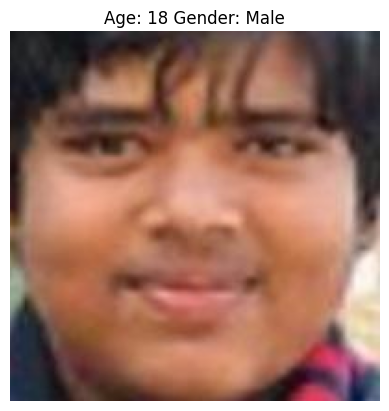

In [10]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

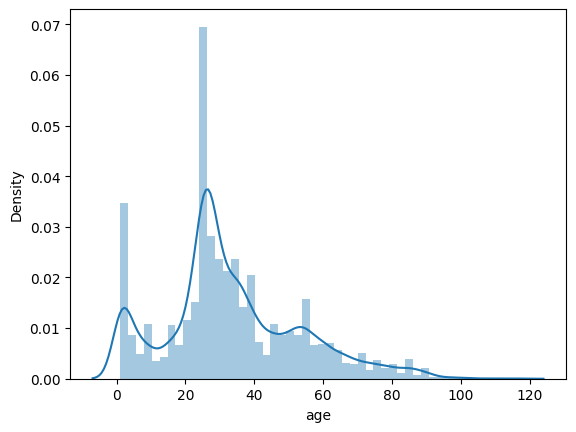

In [13]:
# Age distribution
sns.distplot(df['age'])

<Axes: ylabel='count'>

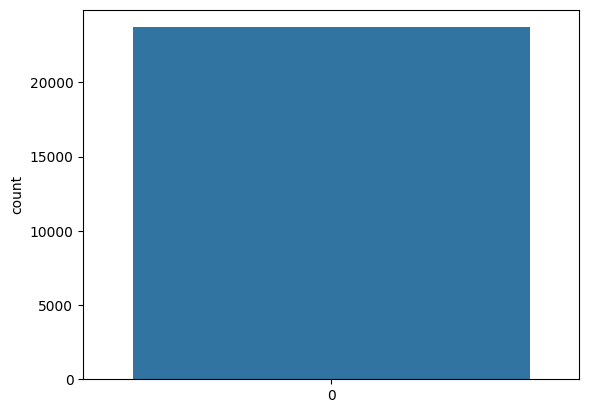

In [14]:
sns.countplot(df['gender'])

In [15]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [16]:
# Feature Extraction

In [17]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [18]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [19]:
X.shape

(23708, 128, 128, 1)

In [20]:
X = X / 255.0

In [21]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [22]:
input_shape = (128, 128, 1)

In [23]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

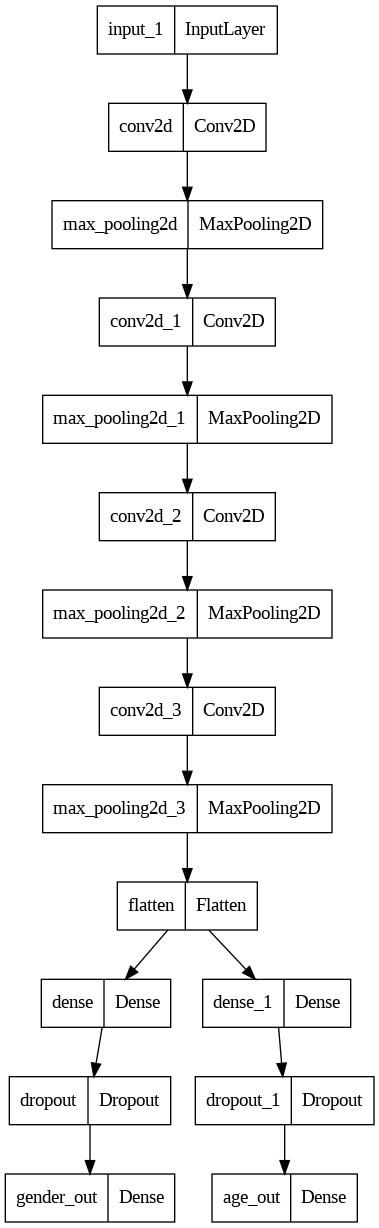

In [24]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [25]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
593/593 [==============================] - 23s 24ms/step - loss: 15.9235 - gender_out_loss: 0.6866 - age_out_loss: 15.2370 - gender_out_accuracy: 0.5599 - age_out_accuracy: 0.0485 - val_loss: 12.6036 - val_gender_out_loss: 0.5583 - val_age_out_loss: 12.0453 - val_gender_out_accuracy: 0.7086 - val_age_out_accuracy: 0.0401
Epoch 2/50
593/593 [==============================] - 12s 20ms/step - loss: 11.3873 - gender_out_loss: 0.4744 - age_out_loss: 10.9128 - gender_out_accuracy: 0.7733 - age_out_accuracy: 0.0279 - val_loss: 10.4508 - val_gender_out_loss: 0.4573 - val_age_out_loss: 9.9934 - val_gender_out_accuracy: 0.7792 - val_age_out_accuracy: 0.0162
Epoch 3/50
593/593 [==============================] - 13s 21ms/step - loss: 9.7759 - gender_out_loss: 0.4060 - age_out_loss: 9.3699 - gender_out_accuracy: 0.8103 - age_out_accuracy: 0.0152 - val_loss: 9.1227 - val_gender_out_loss: 0.4115 - val_age_out_loss: 8.7111 - val_gender_out_accuracy: 0.7961 - val_age_out_accuracy: 0.0131
Epo

In [26]:
# Plot Results

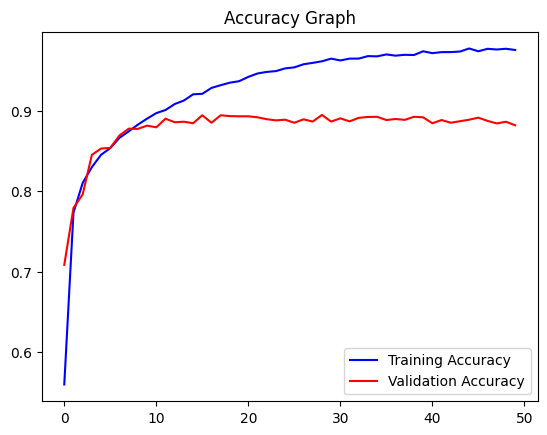

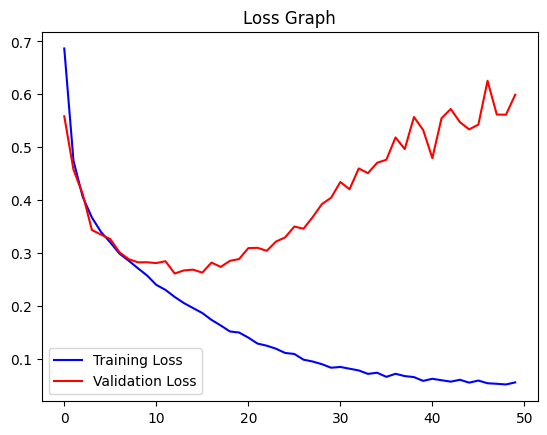

In [27]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

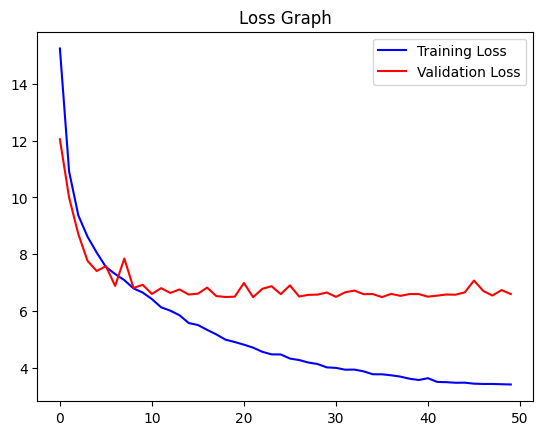

In [28]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [29]:
# Predicting Test Data

In [30]:
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

1/1 [==============================] - 0s 35ms/step


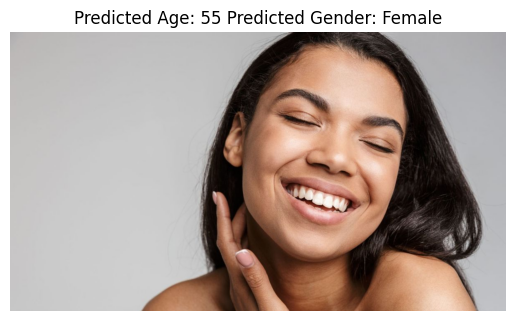

In [34]:
img_to_test = '/content/clean-your-face-naturally-and-organically-using-coconut-oil-resulting-in-calm-beautiful-glowing-skin.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))